## HW 10. Clustering Business

* Cluster time trends in NYC businesses: 

Data: Census Business data by ZIP code: http://www.census.gov/econ/cbp/download/


In [ ]:
# download census data
#$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

#$ for ((y=0; y<=9; y+=1)); do curl -O ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#$ for ((y=10; y<=15; y+=1)); do curl -O ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

* NYC ZIP code shape file:

http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import urllib2
import scipy.stats as stats
%pylab inline 
import statsmodels.formula.api as smf
import pandas as pd
import zipfile
from descartes import PolygonPatch
import json
import glob, os

import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN

Populating the interactive namespace from numpy and matplotlib


In [2]:
colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

## Data Cleaning

In [3]:
url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson"
request = urllib2.urlopen(url)
nyc_zipcodes = json.load(request)
nyc_zip = []
for department in nyc_zipcodes['features']:
    nyc_zip.append(str(department['properties']["postalCode"]))

In [4]:
a = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,1994,1995,1996,1997,1998,1999]
a[2]

2002

In [5]:
fname = ('zbp00totals.zip')
zf = zipfile.ZipFile(fname)
ini= pd.read_csv(zf.open(fname.replace('.zip','.txt')))
ini = ini.rename(columns={'ZIP': 'zip', 'EST': 'est'})
ini['year']=2000
ini = ini[['zip','est']]
#ini = pd.DataFrame
#ini = pd.DataFrame(columns=['zip'])

a = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,1994,1995,1996,1997,1998,1999]
i = 1
for fname in glob.glob('*.zip'):
    print fname
    if fname==('zbp00totals.zip'):
        continue
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    if 'zip' not in df.columns:
        df = df.rename(columns={'ZIP': 'zip', 'EST': 'est'})
    df['year']=a[i]
    df = df[['zip', 'est']]
    ini = pd.merge(ini,df,on='zip')
    i += 1

zbp00totals.zip
zbp01totals.zip
zbp02totals.zip
zbp03totals.zip
zbp04totals.zip
zbp05totals.zip
zbp06totals.zip
zbp07totals.zip
zbp08totals.zip
zbp09totals.zip
zbp10totals.zip
zbp11totals.zip
zbp12totals.zip
zbp13totals.zip
zbp94totals.zip
zbp95totals.zip
zbp96totals.zip
zbp97totals.zip
zbp98totals.zip
zbp99totals.zip


In [6]:
ini.head()

zip  est_x  est_y  est_x  est_y  est_x  est_y  est_x  est_y  est_x  ...    \
0  1001    493    490    490    505    500    509    509    503    477  ...     
1  1002    563    587    566    586    584    589    582    596    584  ...     
2  1003     13     13     15     16     15     12     12     16     17  ...     
3  1004     48     37     23     21     43     31     30     20     18  ...     
4  1005     86     90     94     93     97     94     98    106     97  ...     

   est_x  est_y  est_x  est_y  est_x  est_y  est_x  est_y  est_x  est_y  
0    448    436    453    439    439    439    433    457    444    469  
1    570    558    572    572    450    467    487    500    490    558  
2     16     16     15     15     10     10     13     15     14     13  
3     21     19     16     16     47     48     47     41     31     35  
4     96     91     94     97     92     95    101    104     95     82  

[5 rows x 21 columns]

In [7]:
ini.columns=['zip',2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,1994,1995,1996,1997,1998,1999]
mydata=pd.DataFrame()

In [8]:
data = ini[(ini['zip'].astype(str).isin(nyc_zip))]

In [9]:
data.columns=['zip',2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,1994,1995,1996,1997,1998,1999]
#data.columns=['zip','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','1994','1995','1996','1997','1998','1999']
data.head()

zip  2000  2001  2002  2003  2004  2005  2006  2007  2008  ...   2010  \
2758  10001  7317  7188  7141  7084  7370  7312  7415  7549  7472  ...   7241   
2759  10002  2277  2543  2269  2402  2551  2682  2686  2685  2691  ...   2872   
2760  10003  3683  3602  3616  3704  3776  3867  3909  4049  4071  ...   4113   
2761  10004  1294  1247  1253  1252  1283  1260  1311  1370  1376  ...   1398   
2762  10005  1287  1249  1244  1200  1226  1214  1259  1273  1291  ...   1266   

      2011  2012  2013  1994  1995  1996  1997  1998  1999  
2758  7227  7235  7273  6999  7088  7075  7154  7254  7233  
2759  2912  2954  2988  1784  1819  1919  2049  2003  2085  
2760  4159  4214  4277  3256  3377  3417  3535  3649  3659  
2761  1404  1442  1479  1115  1124  1133  1173  1176  1233  
2762  1301  1273  1296  1076  1109  1216  1227  1270  1242  

[5 rows x 21 columns]

In [10]:
zp = []
for i in data['zip']:
    zp.append(i)

In [11]:
data.to_csv('data.csv')
white_data = pd.read_csv('data.csv')
del white_data['Unnamed: 0']
len(zp)

230

* Sanity check: have 20(Ntimestamps) datapoints per time series and about 250 zipcodes(Nzipcodes)
* Whitening your data: divide each feature by its standard deviation

Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix. Whitening your data in time series analysis is in most cases wrong: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

* data formats:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))

### Tasks:
1. get and prep your data.
2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
4. Use another clustering algorithm (of your choice)
5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
6. Compare the results of the 2 algorithms
7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 

## Whitening data

In [12]:
white_data.head()

zip  2000  2001  2002  2003  2004  2005  2006  2007  2008  ...   2010  \
0  10001  7317  7188  7141  7084  7370  7312  7415  7549  7472  ...   7241   
1  10002  2277  2543  2269  2402  2551  2682  2686  2685  2691  ...   2872   
2  10003  3683  3602  3616  3704  3776  3867  3909  4049  4071  ...   4113   
3  10004  1294  1247  1253  1252  1283  1260  1311  1370  1376  ...   1398   
4  10005  1287  1249  1244  1200  1226  1214  1259  1273  1291  ...   1266   

   2011  2012  2013  1994  1995  1996  1997  1998  1999  
0  7227  7235  7273  6999  7088  7075  7154  7254  7233  
1  2912  2954  2988  1784  1819  1919  2049  2003  2085  
2  4159  4214  4277  3256  3377  3417  3535  3649  3659  
3  1404  1442  1479  1115  1124  1133  1173  1176  1233  
4  1301  1273  1296  1076  1109  1216  1227  1270  1242  

[5 rows x 21 columns]

In [13]:
#white_data.index=zip
white_data.index = zp
del white_data['zip']
white_data.head()

2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  \
10001  7317  7188  7141  7084  7370  7312  7415  7549  7472  7305  7241  7227   
10002  2277  2543  2269  2402  2551  2682  2686  2685  2691  2775  2872  2912   
10003  3683  3602  3616  3704  3776  3867  3909  4049  4071  4099  4113  4159   
10004  1294  1247  1253  1252  1283  1260  1311  1370  1376  1379  1398  1404   
10005  1287  1249  1244  1200  1226  1214  1259  1273  1291  1274  1266  1301   

       2012  2013  1994  1995  1996  1997  1998  1999  
10001  7235  7273  6999  7088  7075  7154  7254  7233  
10002  2954  2988  1784  1819  1919  2049  2003  2085  
10003  4214  4277  3256  3377  3417  3535  3649  3659  
10004  1442  1479  1115  1124  1133  1173  1176  1233  
10005  1273  1296  1076  1109  1216  1227  1270  1242

In [14]:
for i in range(len(white_data)):
    white_data.iloc[i] = (white_data.iloc[i]-np.mean(white_data.iloc[i]))/np.std(white_data.iloc[i])

In [15]:
finaldt = pd.DataFrame(white_data['1994'])
for i in range(1995,2014):
    finaldt[i]=white_data[str(i)]

In [16]:
finaldt.head()

1994      1995      1996      1997      1998      1999      2000  \
10001 -1.831632 -1.173250 -1.269418 -0.685012  0.054742 -0.100607  0.520787   
10002 -1.722813 -1.631907 -1.372173 -1.034519 -1.153997 -0.941015 -0.442326   
10003 -1.872528 -1.457250 -1.319968 -0.914985 -0.523731 -0.489411 -0.407041   
10004 -1.608897 -1.523770 -1.438643 -1.060302 -1.031926 -0.492790  0.084181   
10005 -2.885957 -2.304004 -0.417066 -0.223082  0.535220  0.041442  0.835014   

           2001      2002      2003      2004      2005      2006      2007  \
10001 -0.433496 -0.781180 -1.202840  0.912857  0.483799  1.245746  2.237017   
10002  0.248565 -0.463105 -0.117659  0.269344  0.609595  0.619984  0.617387   
10003 -0.685038 -0.636989 -0.334968 -0.087861  0.224456  0.368602  0.849090   
10004 -0.360370 -0.303619 -0.313078 -0.019863 -0.237409  0.244976  0.803030   
10005  0.164887  0.076712 -0.699225 -0.240717 -0.452336  0.341236  0.588125   

           2008      2009      2010      2011      2012      2013  
10001  1.667406  0.432016 -0.041426 -0.144992 -0.085811  0.195295  
10002  0.632971  0.851147  1.103089  1.206982  1.316071  1.404380  
10003  0.924595  1.020693  1.068741  1.226616  1.415379  1.631598  
10004  0.859781  0.888157  1.067869  1.124620  1.484044  1.834010  
10005  0.905554  0.605760  0.464681  1.081903  0.588125  0.993729

## K means clustering

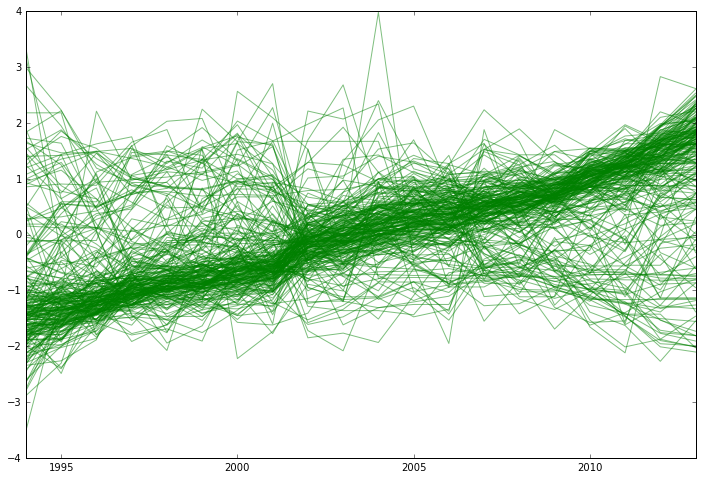

In [17]:
plt.figure(figsize=(12,8))
plt.xlim(1994,2013)
for i in range(len(finaldt)):
    plt.plot(finaldt.iloc[i].index, finaldt.iloc[i],'g', alpha=0.5)

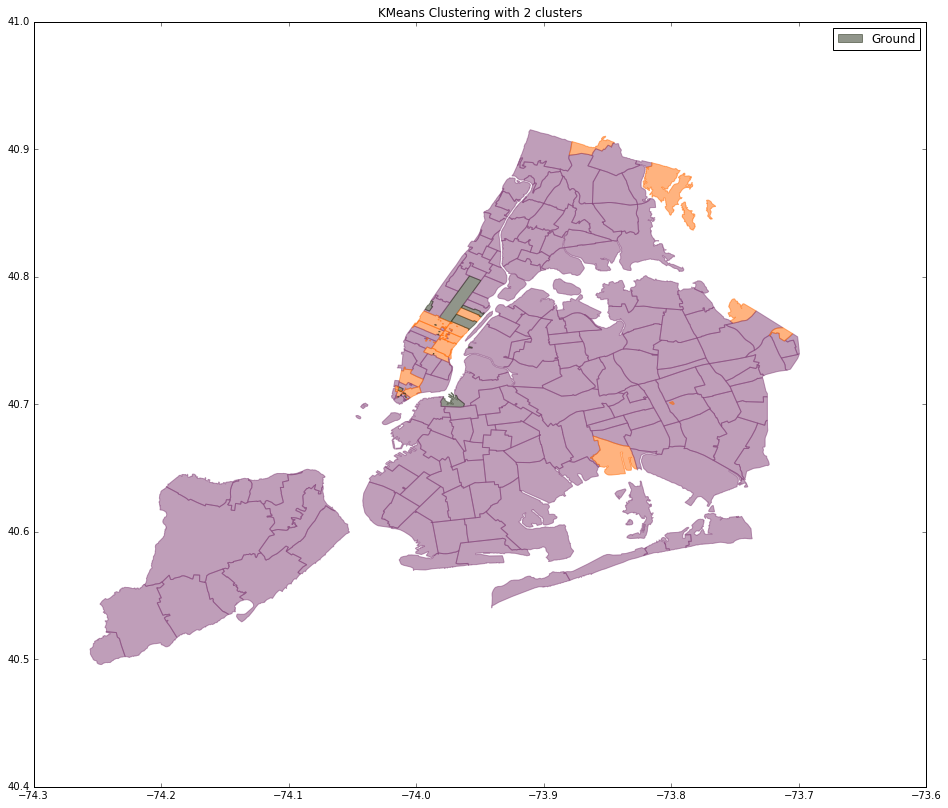

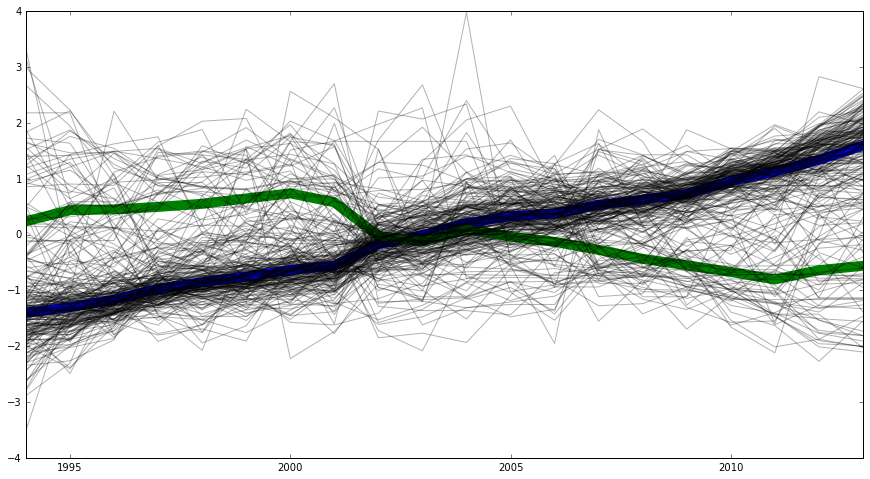

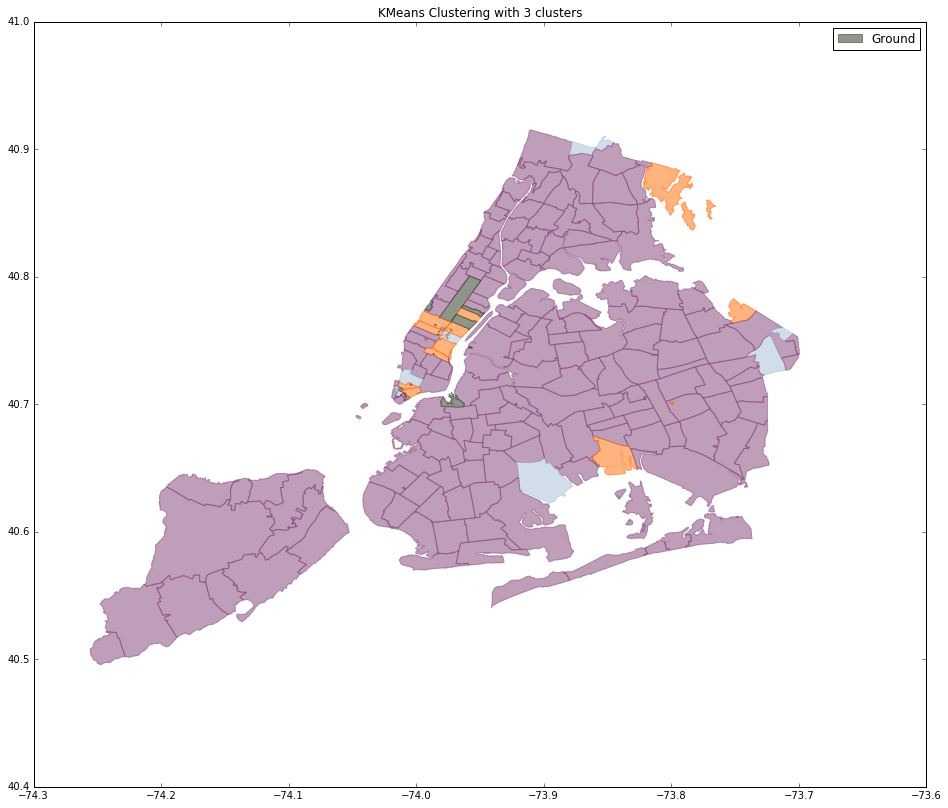

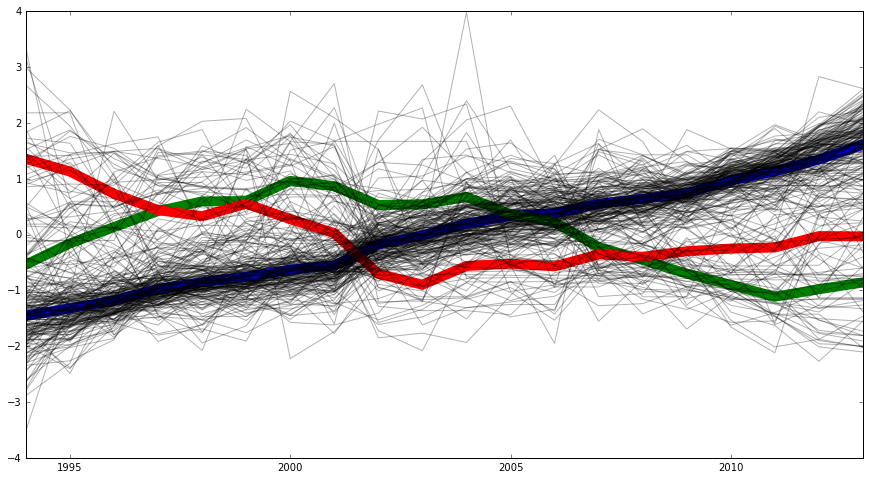

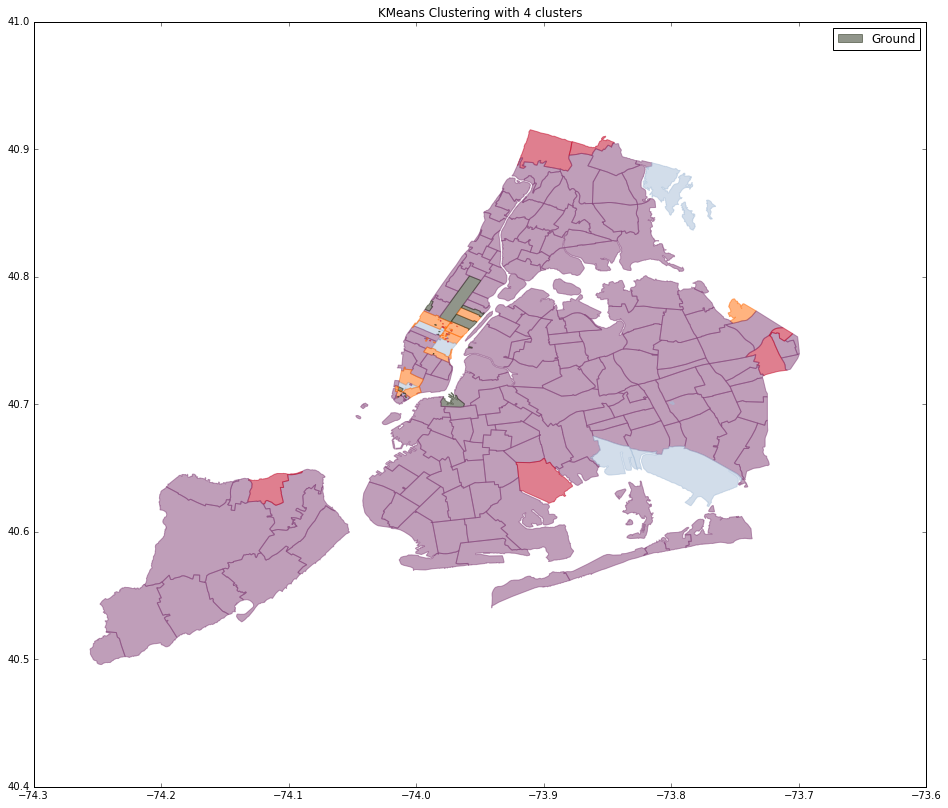

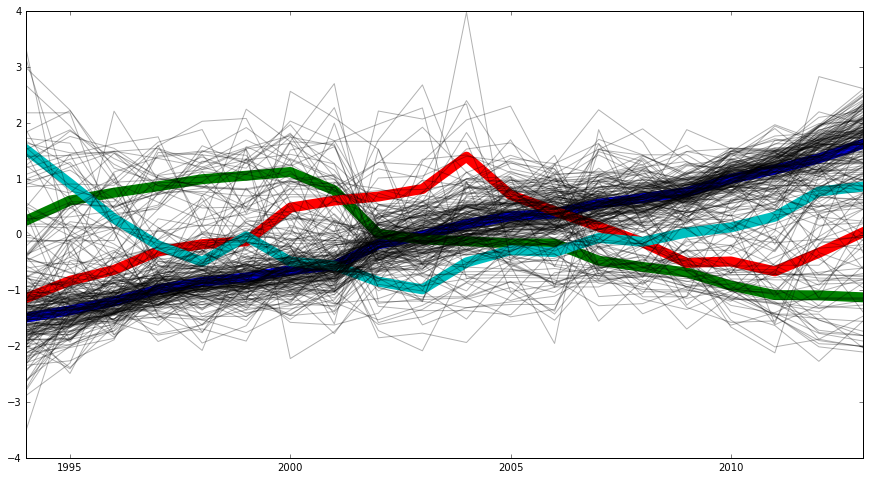

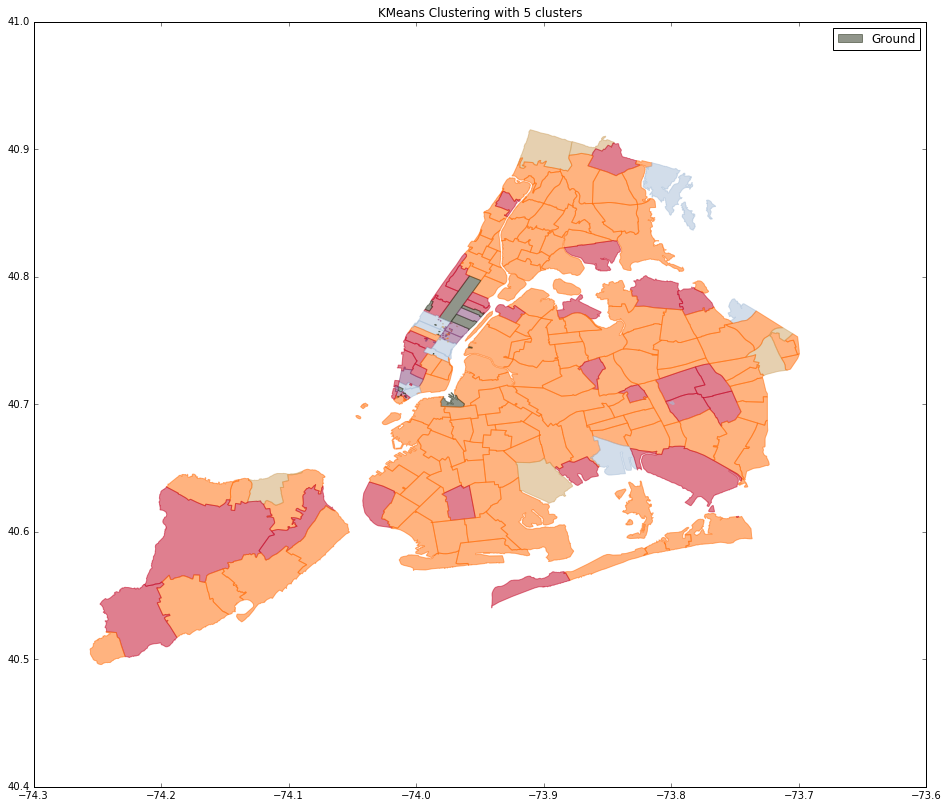

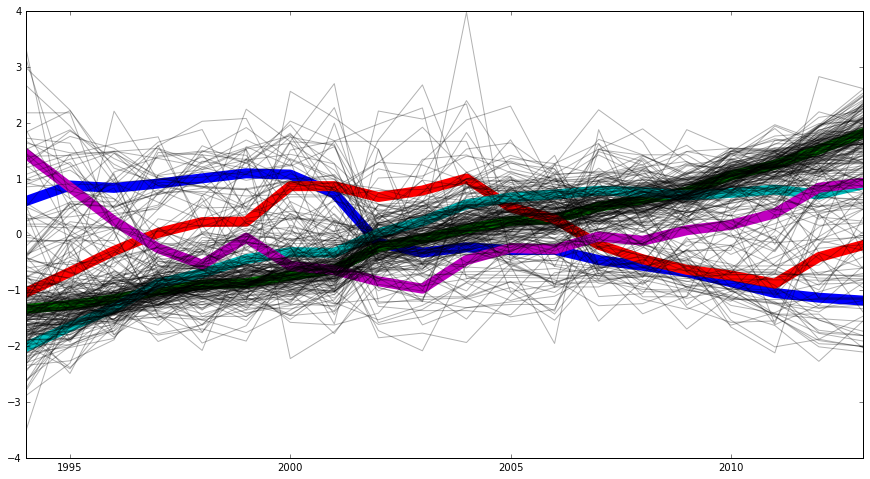

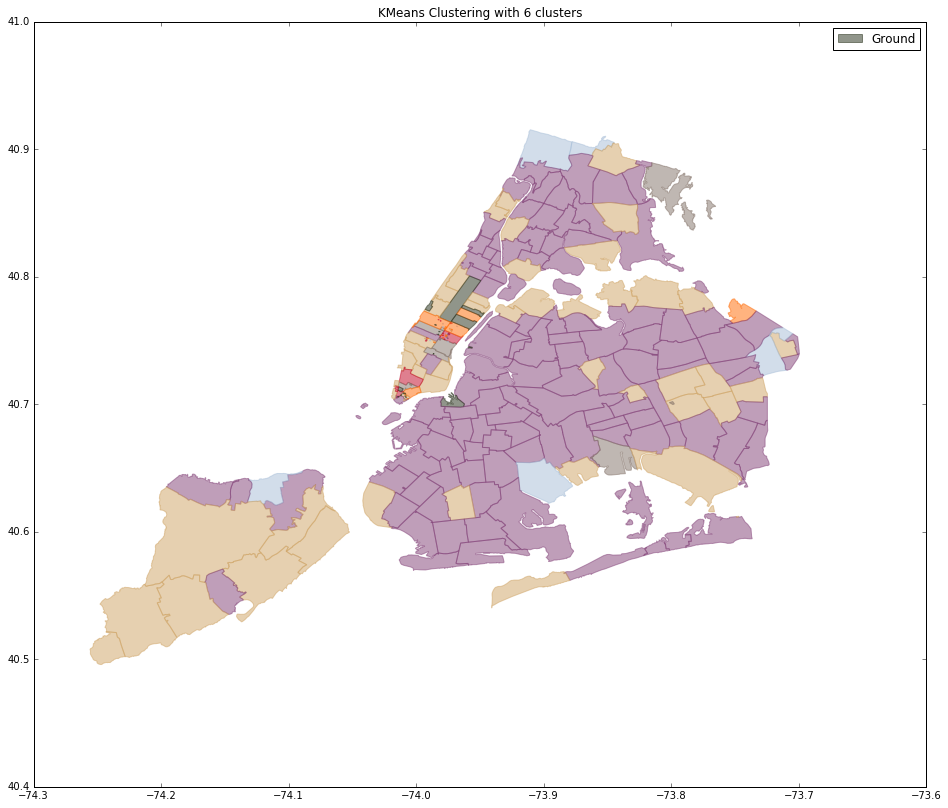

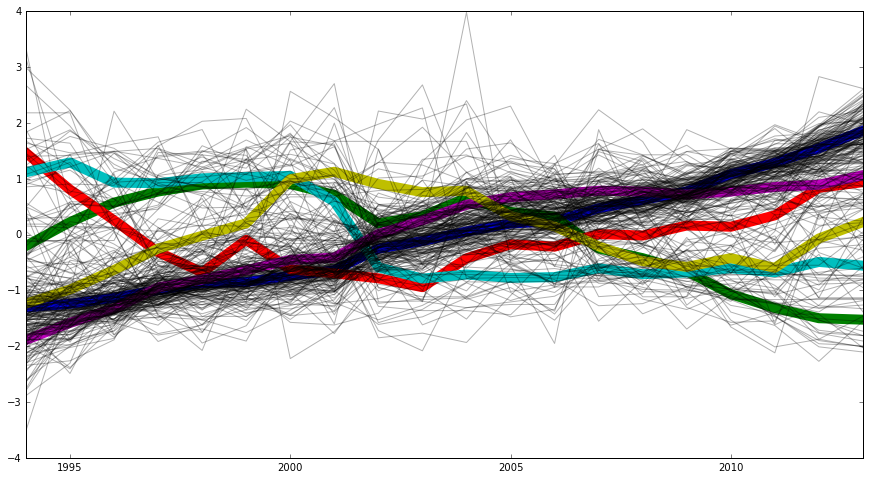

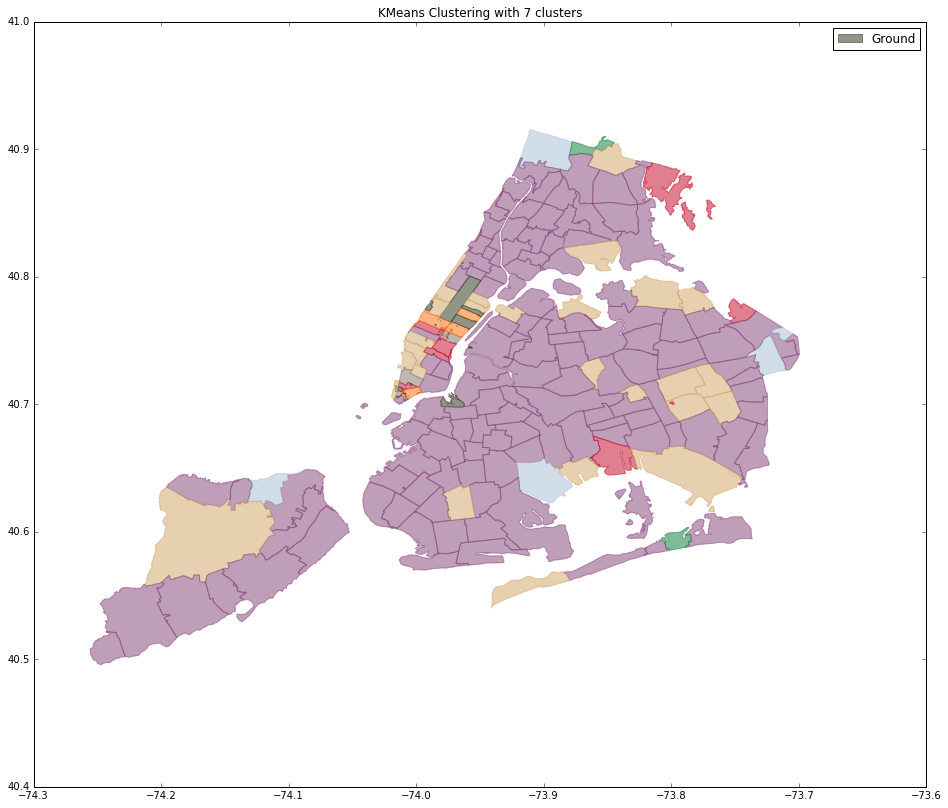

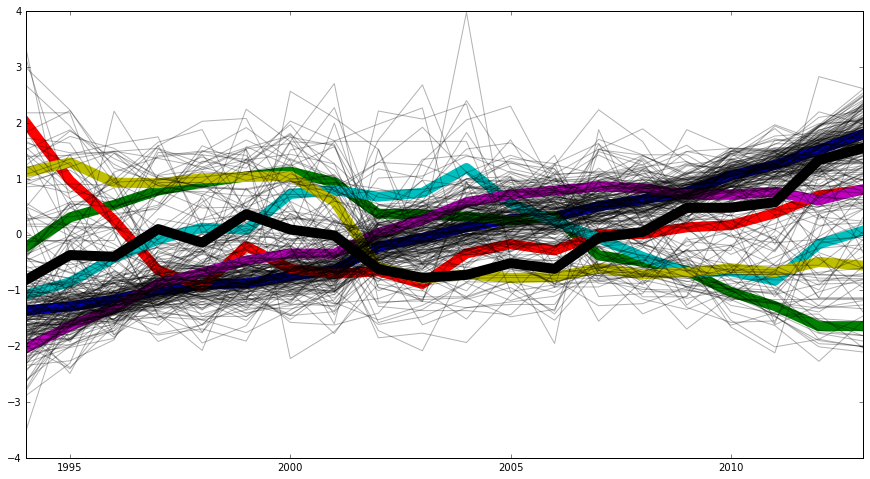

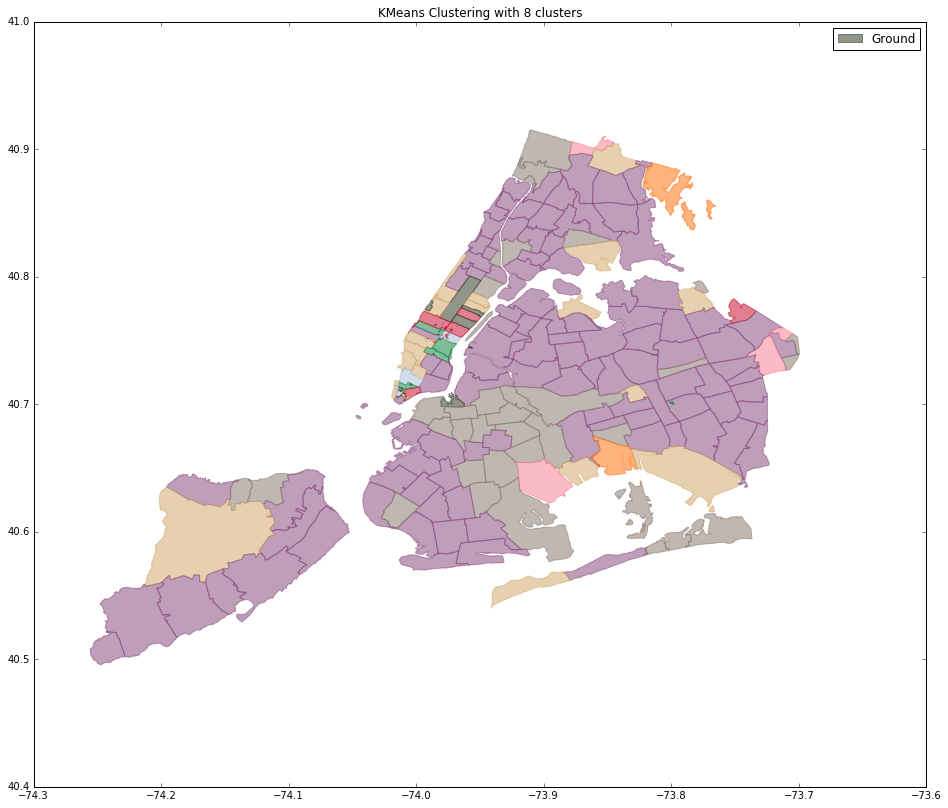

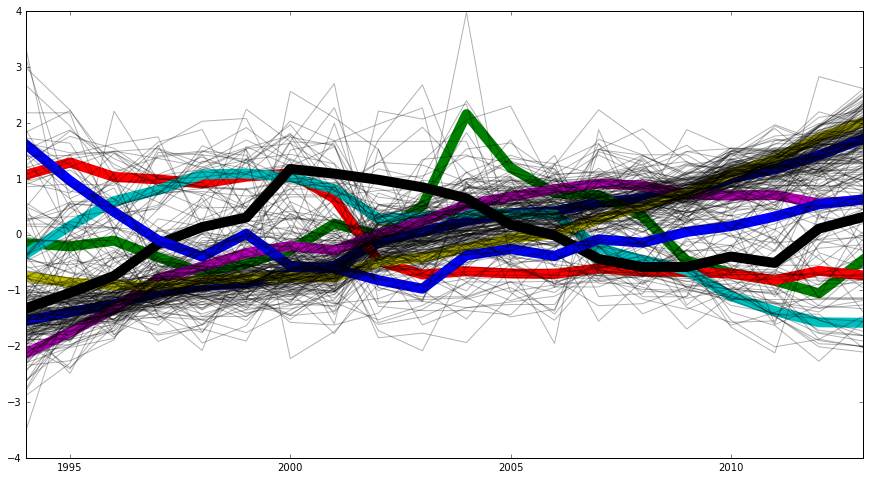

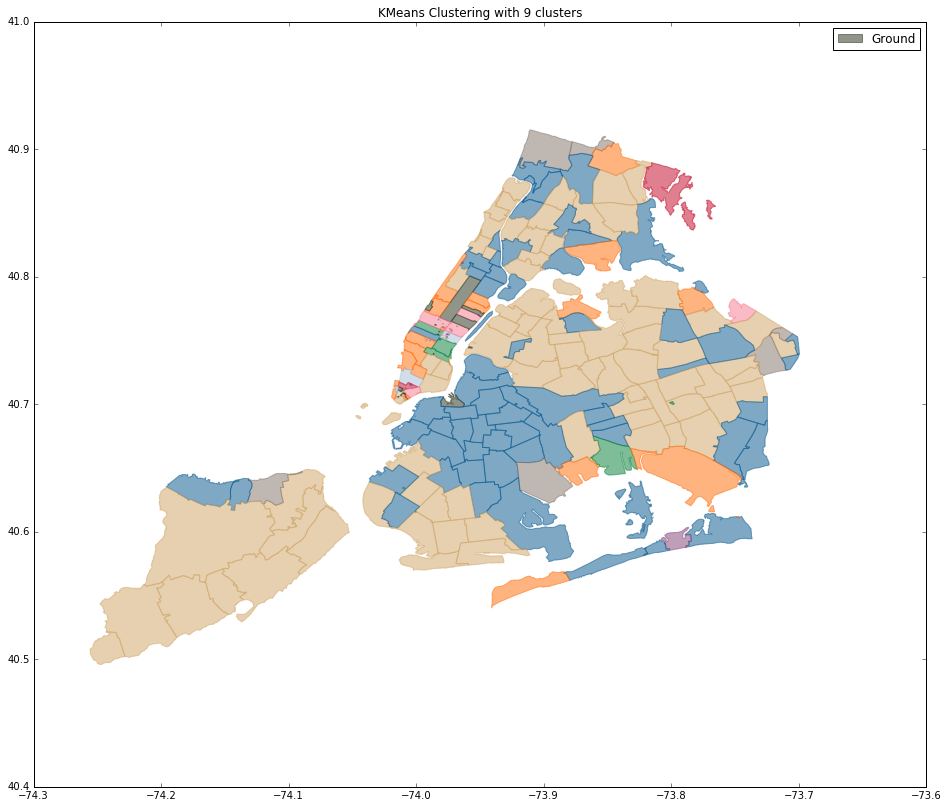

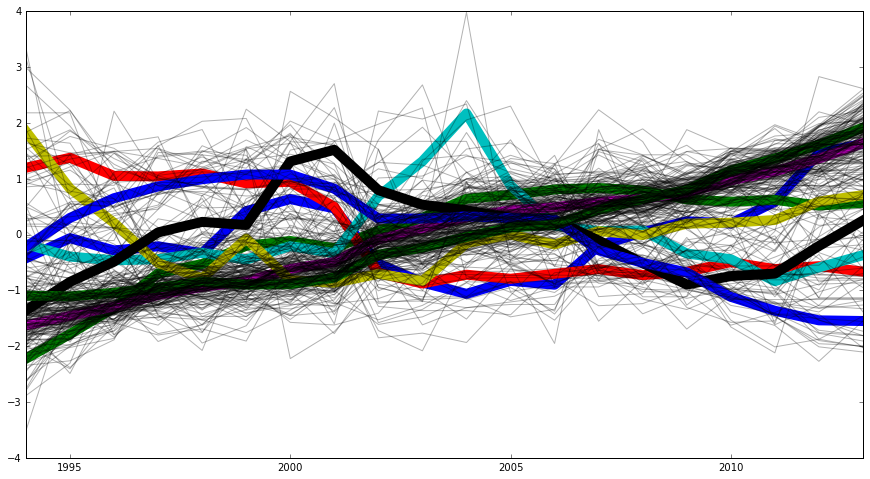

In [18]:
finaldt = finaldt.dropna()
sh_scores = {}

# kmeans clustering from 2 to 9
for n in range(2,10):
    kmeans = sklearn.cluster.KMeans(n_clusters=n)
    kmeans.fit(finaldt.values)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    # Compute the Silhouette score
    sh_avg = silhouette_score(finaldt.values, kmeans.labels_)
    sh_scores[n] = sh_avg
    
    cluster = labels
    clustered_zip = pd.DataFrame({'zip':finaldt.index, 'cluster':cluster})
    fig = plt.figure(figsize=(16,18))
    
    for i in nyc_zipcodes['features']:
        poly = i['geometry']
        postcode = int(i['properties']['postalCode'])
        ax = fig.gca()
        GR = colors_hex[19]
        if postcode in list(finaldt.index):
            color = colors_hex[int(clustered_zip[clustered_zip['zip']==postcode]['cluster'])+1]
            ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2))
        else:
            ax.add_patch(PolygonPatch(poly, fc=GR, ec=GR, alpha=0.5, zorder=2))
    ax.axis('scaled')
    import matplotlib.patches as mpatches
    
    ground = mpatches.Patch(color=GR, alpha=0.5, label='Ground')
    plt.legend(handles=[ground], loc='best')
    plt.title('KMeans Clustering with %s clusters'%(n))
    plt.figure(figsize=(15,8))
    plt.xlim(1994,2013)
    for i in range(len(centers)):
        plt.plot(range(1994,2014),centers[i],linewidth=10) 
    for i in range(len(finaldt)):
        plt.plot(finaldt.iloc[i].index, finaldt.iloc[i],'k',alpha=0.3)

In [19]:
for shc in sh_scores:
    print 'For {0} number of centers, the silhouette value is {1}'.format(shc,sh_scores[shc])

For 2 number of centers, the silhouette value is 0.561611135742
For 3 number of centers, the silhouette value is 0.535367795322
For 4 number of centers, the silhouette value is 0.49164230844
For 5 number of centers, the silhouette value is 0.261755588753
For 6 number of centers, the silhouette value is 0.215068217125
For 7 number of centers, the silhouette value is 0.276067792337
For 8 number of centers, the silhouette value is 0.199611763074
For 9 number of centers, the silhouette value is 0.143431877385


## Try with other clustering method

* Agglomerative clustering

In [25]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters = 7, compute_full_tree=True).fit(finaldt)

In [27]:
print agg

AgglomerativeClustering(affinity='euclidean', compute_full_tree=True,
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=7, n_components=None,
            pooling_func=<function mean at 0x104f8bcf8>)
